<a href="https://colab.research.google.com/github/dimeking/playground/blob/master/Covid_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/CSSEGISandData/COVID-19

Cloning into 'COVID-19'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 22270 (delta 1), reused 3 (delta 0), pack-reused 22254
Receiving objects: 100% (22270/22270), 96.71 MiB | 29.27 MiB/s, done.
Resolving deltas: 100% (12006/12006), done.


In [0]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from google.colab import widgets
from google.colab import output

colors = list(mcolors.TABLEAU_COLORS.keys())
date_offset = 41 # Mar 1, 2020

def get_datafile(case_type):
  file_name = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_'+case_type+'_global.csv'
  df = pd.read_csv(file_name)
  return df.drop(columns =['Lat', 'Long'])

def get_region(dataframe, region, split_region):
  region_rows = dataframe.loc[dataframe['Country/Region']==region]

  if region == 'Canada':
    region_rows = region_rows.drop(region_rows.index[region_rows['Province/State'].str.contains('Princess')].tolist())
    # region_rows = region_rows.drop(region_rows.index[region_rows['Province/State'].str.contains(', ')].tolist())
  
  # print(region_rows)
  if region_rows.shape[0] > 1 and not split_region:
    if region_rows.iloc[-1,0]==None: 
      region_rows.iloc[-1,0] = 'Mainland' 
    region_rows = region_rows.cumsum(axis=0, skipna=True)
    region_rows = region_rows.iloc[-1:,:] #last row has sum values
    region_rows.iloc[0][0] = None
    region_rows.iloc[0][1] = region

  # print(region+": ", region_rows)
  return region_rows

def get_regions(dataframe, regions):
  region_rows = dataframe.loc[dataframe['Country/Region'].isin(regions)]
  # print(regions+": ", region_rows)
  return region_rows


In [0]:
def get_region_chunks(dataframe, region_name, chunk_size, max_chunks):

  region_rows = pd.DataFrame(columns=dataframe.columns)
  countries = []
  # if region_name == 'SF BayArea Counties':
  #   counties = ['Santa Clara County, CA', 'San Francisco County, CA', 'San Mateo County, CA', 
  #               'Sonoma County, CA', 'Alameda County, CA', 'Contra Costa County', 
  #               'Napa County, CA', 'Marin County, CA', 'Solano County, CA']
  #   region_rows = dataframe.loc[dataframe['Province/State'].isin(regions)]
  # elif region_name == 'US States':
  #   region_rows = get_region(dataframe, 'US', True)
  if region_name == 'Canada Provinces':
    region_rows = get_region(dataframe, 'Canada', True)
  elif region_name == 'Australia Provinces':
    region_rows = get_region(dataframe, 'Australia', True)
  elif region_name == 'China Provinces':
    region_rows = get_region(dataframe, 'China', True)
  elif region_name == 'World':
    countries = ['Italy', 'Korea, South', 'Iran', 'Spain', 'Germany', 'US', 'Japan', 'United Kingdom', 'France', 'China'] 
  elif region_name == 'West Europe':
    countries = ['Italy', 'Germany', 'Spain', 'United Kingdom', 'France', 'Netherlands', 'Switzerland', 'Portugal', 'Greece', 'Croatia'] 
  elif region_name == 'East Europe':
    countries = ['Hungary', 'Bulgaria', 'Romania', 'Ukraine', 'Belarus', 'Estonia', 'Latvia', 'Lithuania', 'Serbia'] # No China
  elif region_name == 'North Asia':
    countries = ['Korea, South', 'Japan', 'Russia', 'Taiwan*', 'Mongolia'] # No China
  elif region_name == 'Central Asia':
    countries = ['Kazakisthan', 'Georgia', 'Uzbektistan', 'Turkmenistan', 'Azerbhaijan', 'Armenia', 'Tajikistan', 'Kyrgyzstan'] # No China
  elif region_name == 'Middle East':
    countries = ['Israel', 'Saudi Arabia', 'Iraq', 'Lebanon', 'Syria', 'Kuwait', 'Yemen', 'Oman', 'Iran', 'Turkey']
  elif region_name == 'South Asia':
    countries = ['India', 'Pakistan', 'Bangladesh', 'Sri Lanka', 'Nepal', 'Afghanistan']
  elif region_name == 'South East Asia':
    countries = ['Indonesia', 'Malaysia', 'Thailand', 'Singapore', 'Vietnam', 'Philippines', 'Burma', 'Cambodia', 'Laos']
  elif region_name == 'North America':
    countries = ['US', 'Canada', 'Mexico']
  elif region_name == 'Central America':
    countries = ['Mexico', 'Panama', 'Jamaica', 'Cuba', 'Costa Rica', 'Guatemala']
  elif region_name == 'South America':
    countries = ['Brazil', 'Argentina', 'Chile', 'Colombia', 'Venezuela', 'Peru', 'Bolivia', 'Uruguay', 'Paraguay', 'Ecuador']
  elif region_name == 'Africa':
    countries = ['South Africa', 'Nigeria', 'Kenya', 'Morocco', 'Egypt', 'Sudan', 'Algeria', 'Tunisia']
  elif region_name == 'Emerging Markets':
    countries = ['India', 'Brazil', 'Russia', 'Turkey', 'Singapore', 'Mexico']
  else:
    region_rows = get_region(dataframe, region_name, False)

  for country in countries:
    region_rows = region_rows.append(get_region(dataframe, country, False))


  num_chunks = max(1,len(region_rows)/chunk_size)
  return np.array_split(region_rows, num_chunks)[:max_chunks] 


In [0]:
def plot_regions(regions_list, case_types, regions_per_plot, max_plots, split_region):

  tb = widgets.TabBar(regions_list, location='bottom')
    
  for region_name in regions_list:
    with tb.output_to(region_name):
      grid = widgets.Grid(1, len(case_types))
      for idx, case_type in enumerate(case_types):
        with grid.output_to(0,idx):
          
          df = get_datafile(case_type)

          region_chunks = get_region_chunks(df, region_name, regions_per_plot, max_plots)
          # print(region_chunks) 

          # No US data until Mar 9
          offset = date_offset+10 if region_name == 'US States' else date_offset

          for region in region_chunks:
            for i in range(region.shape[0]):
              lbl = region.iloc[i][1]+':'+region.iloc[i][0] if split_region else region.iloc[i][1]
              region.iloc[i,offset:].plot(color=colors[i%regions_per_plot], label=lbl, figsize=(10,8))

            plt.xlabel('Date')
            plt.ylabel('Cumulative Cases')
            plt.title(region_name+' '+case_type+' Cases '+region.columns[-1])
            plt.legend()
            plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

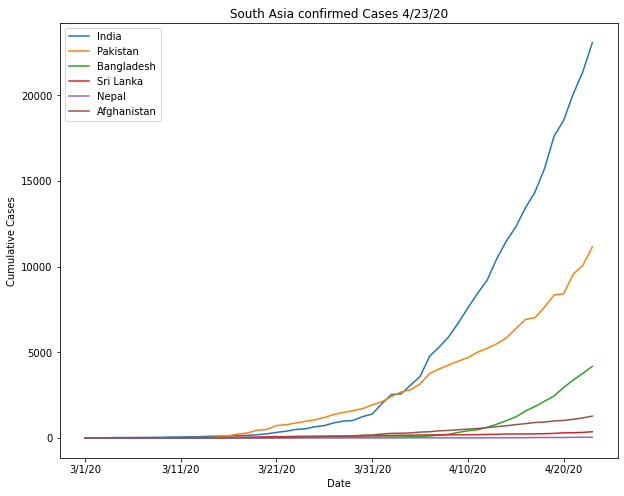

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

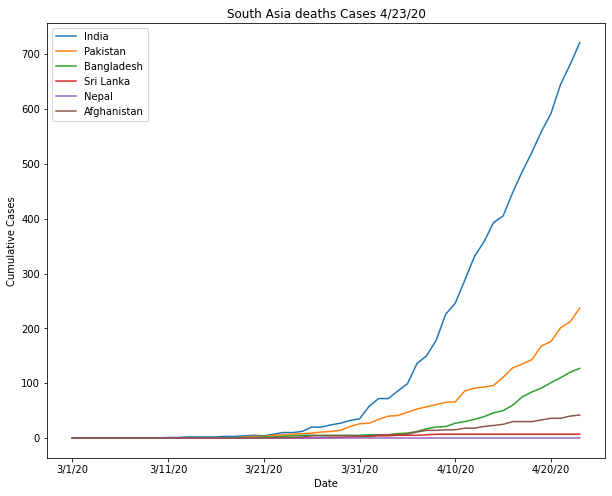

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

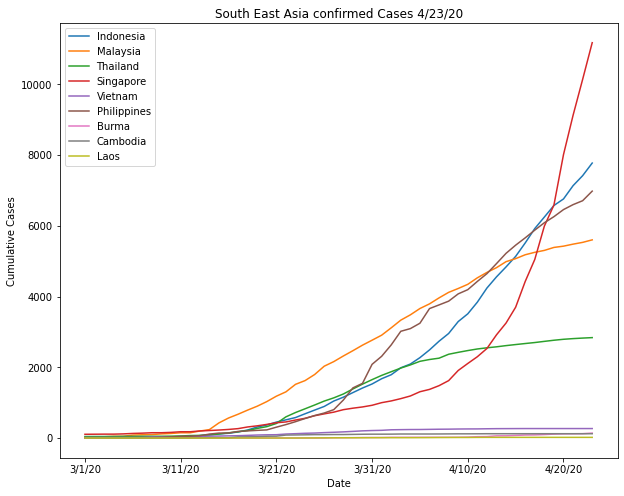

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

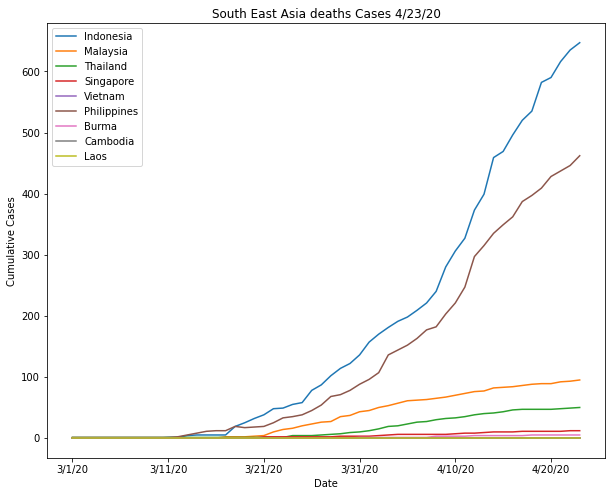

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

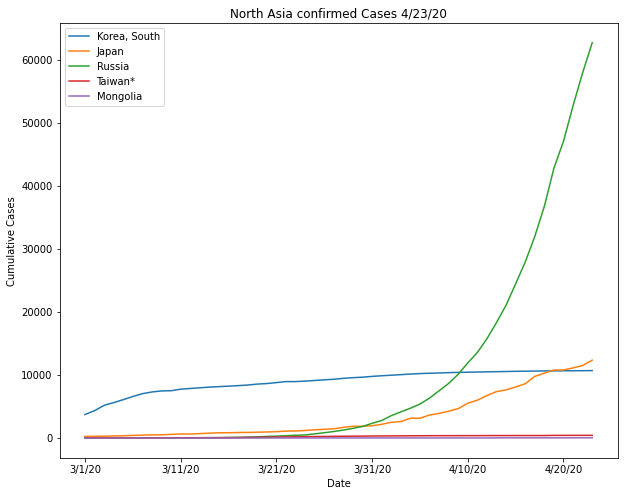

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

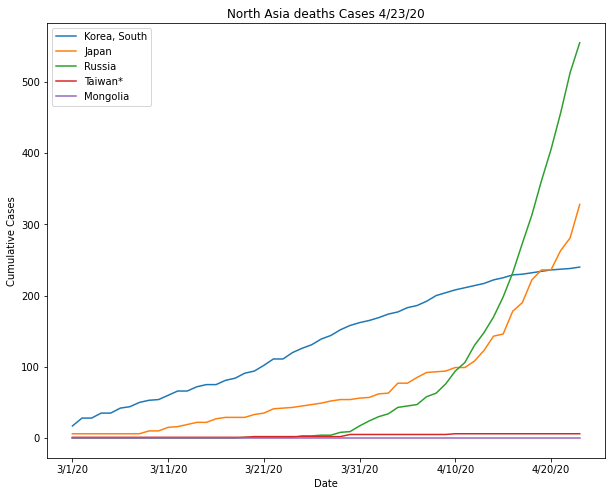

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

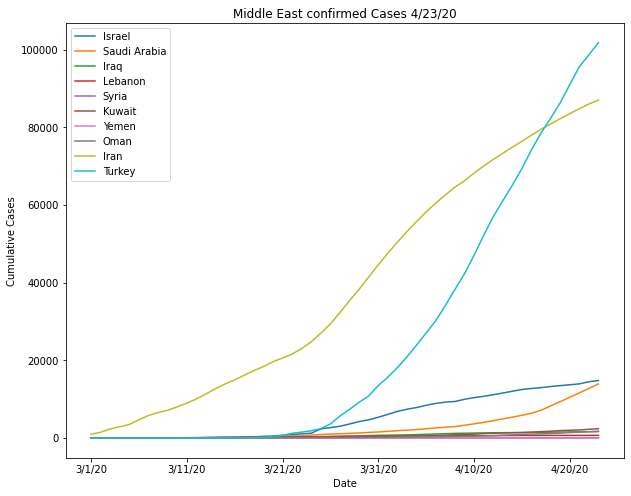

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

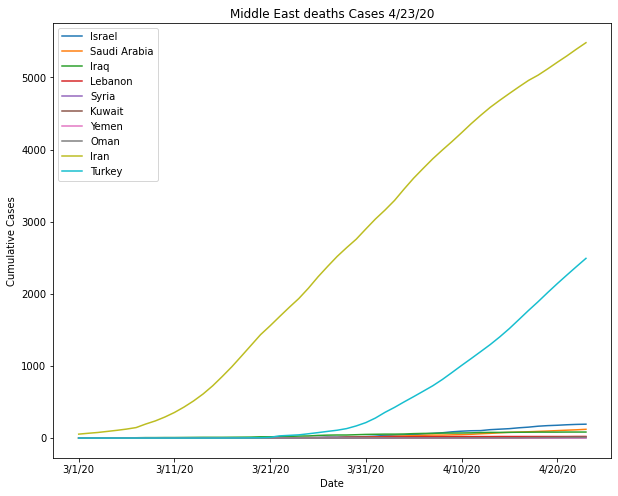

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

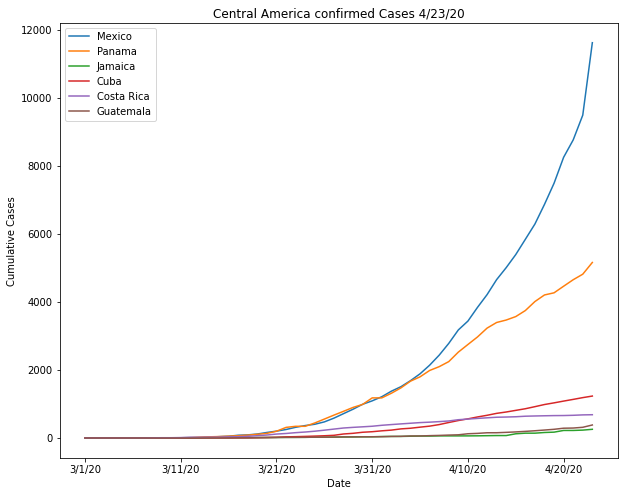

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

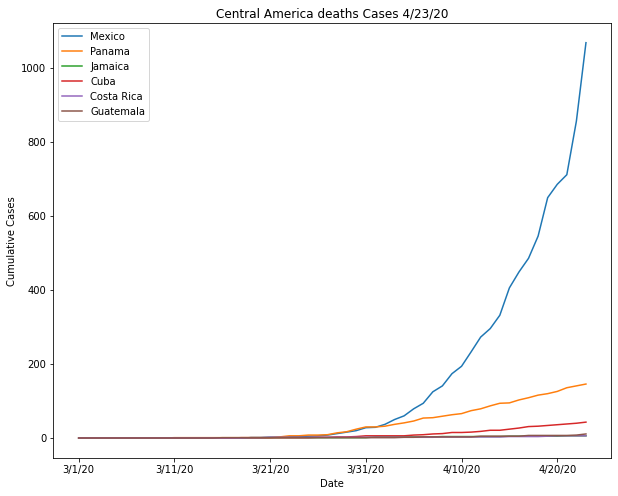

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

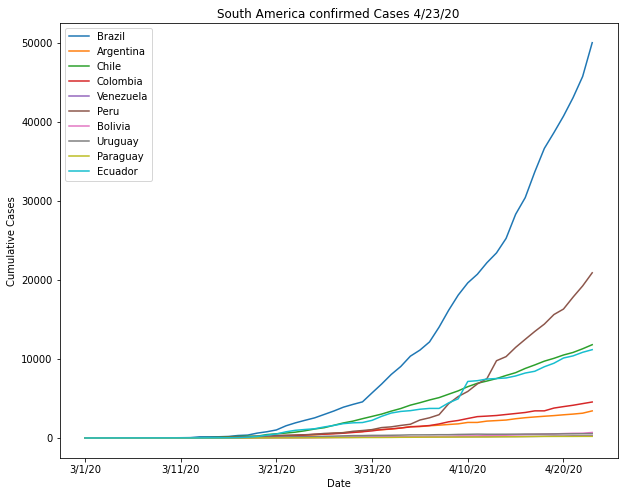

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

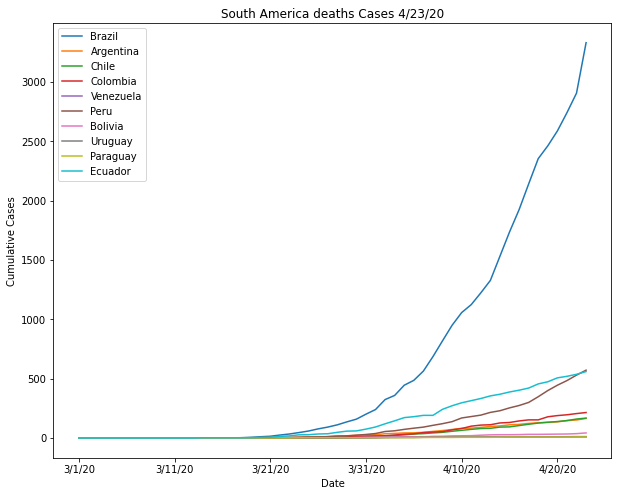

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

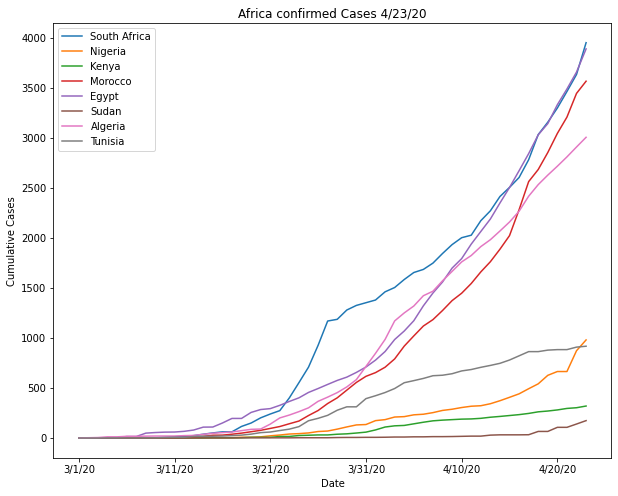

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

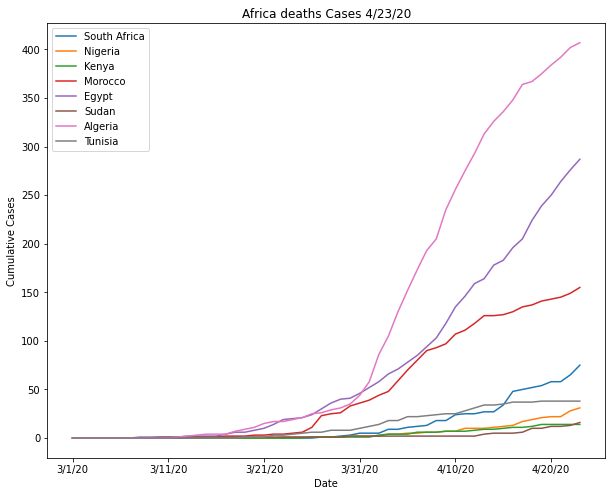

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

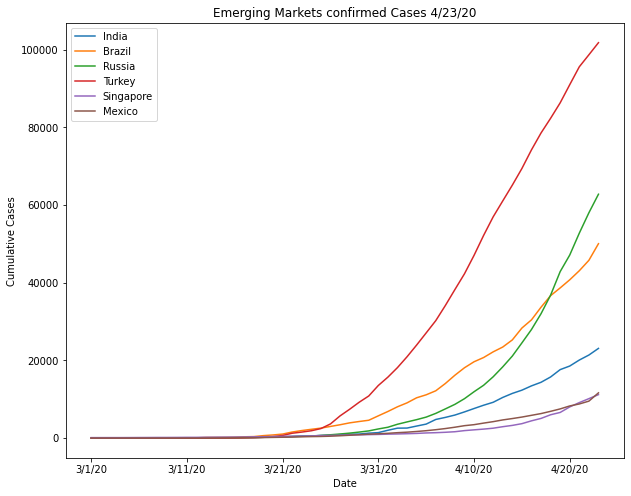

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

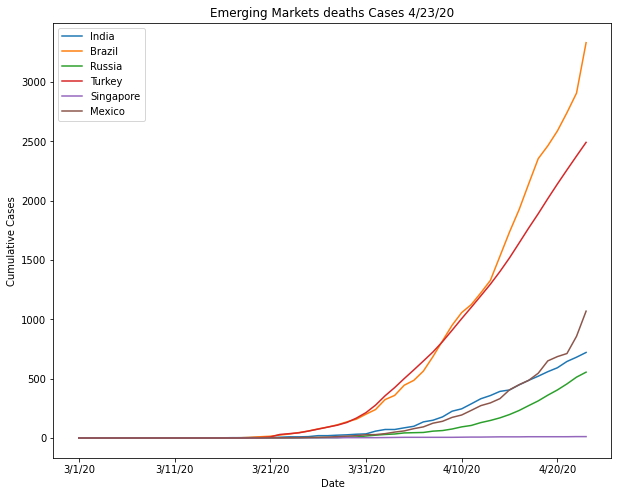

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
# US States:: Map 10 
regions_list = ['Canada Provinces', 'Australia Provinces', 'China Provinces']
# regions_list = ['US States']
subcontinent_list = ['South Asia', 'South East Asia', 'North Asia', 'Middle East', 'Central America', 'South America', 'Africa', 'Emerging Markets'] 
# subcontinent_list = ['World'] 
countries_list = ['Israel', 'India']

case_types = ['confirmed', 'deaths']
# case_types = ['deaths']

# plot_regions(regions_list, case_types, regions_per_plot=10, max_plots=1, split_region=True)
plot_regions(subcontinent_list, case_types, regions_per_plot=10, max_plots=1, split_region=False)
# plot_regions(countries_list, case_types, regions_per_plot=10, max_plots=1, split_region=False)

